# Preamble

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from utils.my_units import *
from superrad import ultralight_boson as ub
from utils.load_pulsars import load_pulsars_fnc

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
rcParams['mathtext.rm'] = 'Times New Roman' 
rcParams['text.usetex'] = True
rcParams['font.family'] = 'times' #'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
fontsize = 14
rcParams.update({'font.size':fontsize})

# Estimate Number of events

## Read in data files

In [19]:
df_pulsars = load_pulsars_fnc()

In [20]:
df_pulsars['NAME'].to_numpy()

array(['J1757-2745', 'B1639+36A/J1641+3627A', 'J1748-3009', 'J0921-5202',
       'J1748-2446C', 'J1910-5959B', 'J1122-3546', 'J1546-5925',
       'J1801-0857A', 'J1551-0658', 'J1748-2446T', 'J1748-2021C',
       'B0021-72C/J0024-7204C', 'J1824-2452E', 'J1911+0101B',
       'B0021-72D/J0024-7204D', 'J1838-0022g', 'J1748-2446ac', 'J1940+26',
       'J0024-7204Z', 'J0024-7204Z', 'J1904+0836g', 'J1953+1844g',
       'J1342+2822F', 'J1803-3002B', 'J1823-3021E',
       'B0021-72L/J0024-7204L', 'J1326-4728E', 'B0021-72G/J0024-7204G',
       'B0021-72G/J0024-7204G', 'J1801-0857C', 'J1801-0857C',
       'B0021-72M/J0024-7204M', 'B0021-72M/J0024-7204M', 'J0125-2327',
       'J1844+0028g', 'J1836-2354B', 'B0021-72H/J0024-7204H',
       'J1930+1403g', 'B0021-72N/J0024-7204N', 'J2045-68', 'J1624-39',
       'J0418+6635', 'J1317-0157', 'J0024-7204S', 'J1308-23'],
      dtype=object)

In [21]:
len(df_pulsars)

46

In [10]:
### Remove pulsars with almost the same frequency, since the resulting number of events will be the same
df_pulsars = df_pulsars.drop([4, 13, 15, 20, 22, 25])
df_pulsars.reset_index(inplace=True)
df_pulsars

,level_0,index,NAME,RAJ,DECJ,F0,F1,F_GW,upper_limits,type,f range or resolution [Hz],fdot range or resolution [Hz/s]
0,0,0.0,J1757-2745,17:57:55,-27:45:40,56.538013,4.17e-17,113.076026,2.620000e-26,fdot,2.760000e-01,2.130000e-14
1,1,1.0,B1639+36A/J1641+3627A,16:41:41,NaN,96.362235,6.75e-16,192.724470,2.380000e-26,fdot,5.750000e-01,2.130000e-14
2,2,0.0,J1748-3009,17:48:24,-30:09:11,103.263527,3.82E-16,206.527054,7.500000e-27,doublet,4.600000e-08,2.110000e-15
3,3,1.0,J0921-5202,9:21,-52:02:00,103.305785,NaN,206.611570,5.800000e-27,doublet,4.600000e-08,2.110000e-15
4,5,3.0,J1910-5959B,19:10:52,-59:59:01,119.648733,1.13e-14,239.297466,2.320000e-26,fdot,6.080000e-01,2.130000e-14
5,6,2.0,J1122-3546,11:22,-35:46:00,128.205128,NaN,256.410256,2.370000e-26,doublet,4.090000e-01,2.130000e-14
6,7,3.0,J1546-5925,15:46,-59:25:00,128.205128,NaN,256.410256,2.360000e-26,doublet,6.470000e-01,2.130000e-14
7,8,4.0,J1801-0857A,18:01:51,-8:57:32,139.360885,9.91e-15,278.721770,3.440000e-26,fdot,2.890000e-01,2.130000e-14
8,9,6.0,J1551-0658,15:51:07,-6:58:07,141.043724,NaN,282.087448,5.700000e-27,doublet,4.600000e-08,2.110000e-15
9,10,7.0,J1748-2446T,17:48:05,-24:46:45,141.145053,NaN,282.290106,2.500000e-26,doublet,5.970000e-01,2.130000e-14


## Functions

In [5]:
# Black hole mass distribution from 2003.03359
Mmin, Mmax = 5, 30
Norm = 0.740741*(Mmax**(1.35)-Mmin**(1.35))/( (Mmax*Mmin)**(1.35))

def dndM(m):
    return 1/Norm*1/m**(2.35)

In [6]:
### Function to compute the strain hTilde as a function of mass, spin, and age

def get_hTilde_grid(freq_GW, MList, aList, tSteps, RMW=20*kpc, tMW = 13.6*1E9*Year):

    hTilde = np.zeros((len(MList), len(aList), tSteps))
    tGrid = np.zeros((len(MList), len(aList), tSteps))

    mu = np.pi*freq_GW*Hz
    
    for i_m, mbh in enumerate(tqdm(MList)):
        alpha = GN*mu*mbh*MSolar

        for i_a, abh0 in enumerate(aList):
            try:
                wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
                if wf.azimuthal_num()==1:
                    tauGW = wf.gw_time() 
                    tauSR = wf.cloud_growth_time() 

                    tTildeMin = tauGW*Second/tMW*1E-4
                    tTildeMax = 1-tauSR*Second/tMW    
                    tListTemp = np.concatenate([[0], np.geomspace(tTildeMin,tTildeMax,tSteps-1)])
                    tGrid[i_m, i_a, :] = tListTemp

                    hTilde[i_m, i_a, :] = wf.strain_char(tListTemp*tMW/Second, dObs=(RMW/Mpc) )

            except ValueError:
                pass 
            
    return hTilde, tGrid

In [7]:
### Function to compute the flux STilde as a function of mass, spin, and age

def get_STilde_grid(freq_GW, MList, aList, tSteps, RMW=20*kpc, tMW = 13.6*1E9*Year):

    STilde = np.zeros((len(MList), len(aList), tSteps))
    tGrid = np.zeros((len(MList), len(aList), tSteps))

    mu = np.pi*freq_GW*Hz
    
    for i_m, mbh in enumerate(tqdm(MList)):
        alpha = GN*mu*mbh*MSolar

        for i_a, abh0 in enumerate(aList):
            try:
                wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
                if wf.azimuthal_num()==1:
                    tauGW = wf.gw_time() 
                    tauSR = wf.cloud_growth_time() 

                    tTildeMin = tauGW*Second/tMW*1E-4
                    tTildeMax = 1-tauSR*Second/tMW    
                    tListTemp = np.concatenate([[0], np.geomspace(tTildeMin,tTildeMax,tSteps-1)])
                    tGrid[i_m, i_a, :] = tListTemp

                    STilde[i_m, i_a, :] = (0.13*alpha-0.19*alpha**2)*wf.mass_cloud(tListTemp*tMW/Second)/(GN*mbh)/(4*np.pi*RMW**2)/(erg/Second/CentiMeter**2)
                    
            except ValueError:
                pass 
            
    return STilde, tGrid

In [8]:
def get_dfdlogh(hVal, hTilde, tGrid, fMList):
    
    thFnc = np.heaviside((1-hTilde/hVal), np.zeros(hTilde.shape))
    integrand = (hTilde/hVal)**3*thFnc
    
    intOvert = np.trapz(integrand, x=tGrid, axis=2)
    intOvera = np.trapz(intOvert, x=aList, axis=1)
    res = 3*np.trapz(fMList*intOvera, x=MList)
    
    return res    

In [9]:
def get_dfdlogS(SVal, STilde, tGrid, fMList, fepsSq):
    
    thFnc = np.heaviside((1-fepsSq*STilde/SVal), np.zeros(STilde.shape))
    integrand = (fepsSq*STilde/SVal)**(3/2)*thFnc
    
    intOvert = np.trapz(integrand, x=tGrid, axis=2)
    intOvera = np.trapz(intOvert, x=aList, axis=1)
    res = 3/2*np.trapz(fMList*intOvera, x=MList)
    
    return res    

In [10]:
def get_dfevdlogM(hVal, hTilde, tGrid, fMList):
    
    thFnc = np.heaviside((1-hTilde/hVal), np.zeros(hTilde.shape))
    integrand = (hTilde/hVal)**3*thFnc
    
    intOvert = np.trapz(integrand, x=tGrid, axis=2)
    intOvera = np.trapz(intOvert, x=aList, axis=1)
    res = 3*fMList*intOvera*MList
    
    return res    

In [11]:
def get_dNevdlogM_ip(Ntot=3000, p_ind=0):
    
    hTilde, tGrid = get_hTilde_grid(df_pulsars['F_GW'].iloc[p_ind], MList, aList, tSteps, RMW, tMW ) # GW frequency must be in Hz    
    hUL = df_pulsars['upper limits'].iloc[p_ind]
    
    dfdlogh = np.zeros( (len(hList), len(MList)) )
    fMList = dndM(MList)
    
    for i_h, hVal in enumerate(tqdm(hList)):    
        dfdlogh[i_h, :] = get_dfevdlogM(hVal, hTilde, tGrid, fMList)
        
    selh = (hList > hUL)
    dNevdlogM = np.zeros( MList.shape )
    for i_m, m in enumerate(MList):
        dNevdlogM[i_m] = Ntot*np.trapz(dfdlogh[selh, i_m]/hList[selh], x=hList[selh], axis=0)

    return dNevdlogM

In [12]:
def get_dfdlogh_ip(hList, p_ind=0):
    hTilde, tGrid = get_hTilde_grid(df_pulsars['F_GW'].iloc[p_ind], MList, aList, tSteps, RMW, tMW ) # GW frequency must be in Hz    
    
    dfdlogh = np.zeros(hList.shape)
    fMList = dndM(MList)

    for i_h, hVal in enumerate(tqdm(hList)):    
        dfdlogh[i_h] = get_dfdlogh(hVal, hTilde, tGrid, fMList)
        
    return dfdlogh

In [13]:
def get_dfdlogS_ip(SList, fepsSq, p_ind=0):
    STilde, tGrid = get_STilde_grid(df_pulsars['F_GW'].iloc[p_ind], MList, aList, tSteps, RMW, tMW) # GW frequency must be in Hz    

    dfdlogS = np.zeros(SList.shape)

    for i_S, SVal in enumerate(tqdm(SList)):    
        dfdlogS[i_S] = get_dfdlogS(SVal, STilde, tGrid, fMList, fepsSq)    
            
    return dfdlogS

In [14]:
def get_Nev_distributions(Ntot=3000, p_ind=0):
    
    hTilde, tGrid = get_hTilde_grid(df_pulsars['F_GW'].iloc[p_ind], MList, aList, tSteps, RMW, tMW ) # GW frequency must be in Hz    
    hUL = df_pulsars['upper limits'].iloc[p_ind]
    
    hList = np.geomspace(1E-2*np.min(hTilde[hTilde>0]), 1E2*np.max(hTilde[hTilde>0]), 300)
    print(1E-2*np.min(hTilde[hTilde>0]), 1E2*np.max(hTilde[hTilde>0]))
    
    ### Get Nev above threshold as a function of BH mass
    dfdlogh = np.zeros( (len(hList), len(MList)) )

    for i_h, hVal in enumerate(tqdm(hList)):    
        dfdlogh[i_h, :] = get_dfevdlogM(hVal, hTilde, tGrid, fMList)
        
    selh = (hList > hUL)
    dNevdlogM = np.zeros( MList.shape )
    for i_m, m in enumerate(MList):
        dNevdlogM[i_m] = Ntot*np.trapz(dfdlogh[selh, i_m]/hList[selh], x=hList[selh], axis=0)

        
    ### Get differential Nev as a functin of frequency
    dfdlogh = np.zeros(hList.shape)

    for i_h, hVal in enumerate(tqdm(hList)):    
        dfdlogh[i_h] = get_dfdlogh(hVal, hTilde, tGrid, fMList)
          
    return dfdlogh, hList, dNevdlogM

## Compute the differential number of events

In [15]:
# Grid of values of M, a and t
MList = np.geomspace(Mmin, Mmax, 100) 
fMList = dndM(MList)
aList = np.linspace(0, 1, 100)
tSteps = 500

# Parameters used for Galactic BH distribution
RMW=20*kpc; tMW = 13.6*1E9*Year

In [16]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

### Example for one frequency

In [23]:
p_ind = 13
hTilde, tGrid = get_hTilde_grid(df_pulsars['F_GW'].iloc[p_ind], MList, aList, tSteps, RMW, tMW ) # GW frequency must be in Hz
df_pulsars['F_GW'].iloc[p_ind]

100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


369.00369

In [24]:
get_dfdlogh(1E-25, hTilde, tGrid, fMList)

1.7096162982606436e-06

In [ ]:
hList = np.geomspace(1E-27, 1E-24, 300)
dfdlogh = np.zeros(hList.shape)

fMList = dndM(MList)

for i_h, hVal in enumerate(tqdm(hList)):    

    dfdlogh[i_h] = get_dfdlogh(hVal, hTilde, fMList)

100%|██████████| 500/500 [00:57<00:00,  8.66it/s]


In [ ]:
hUL = 2E-26

Ntot = 3000
selh = (hList > hUL)
Ntot*np.trapz(dfdlogh[selh]/hList[selh], x=hList[selh])

3.7010164709908415

In [ ]:
dfdlogh

array([1.38793947e-01, 1.39828730e-01, 1.40714039e-01, 1.41847818e-01,
       1.42724281e-01, 1.43726511e-01, 1.44777558e-01, 1.45736809e-01,
       1.46927992e-01, 1.47715064e-01, 1.48866255e-01, 1.49722576e-01,
       1.50895692e-01, 1.51869176e-01, 1.53158704e-01, 1.54274055e-01,
       1.55495401e-01, 1.56752410e-01, 1.57865897e-01, 1.59203921e-01,
       1.60201604e-01, 1.61672560e-01, 1.62827412e-01, 1.64096970e-01,
       1.65547154e-01, 1.66895514e-01, 1.68379740e-01, 1.69744599e-01,
       1.71087478e-01, 1.72619670e-01, 1.73972536e-01, 1.75616298e-01,
       1.76991635e-01, 1.78579791e-01, 1.80134327e-01, 1.81624179e-01,
       1.83277205e-01, 1.84861635e-01, 1.86573723e-01, 1.88195326e-01,
       1.89901999e-01, 1.91635810e-01, 1.93395234e-01, 1.95070262e-01,
       1.96824664e-01, 1.98652102e-01, 2.00496853e-01, 2.02270395e-01,
       2.04212176e-01, 2.06025997e-01, 2.07929253e-01, 2.09955321e-01,
       2.11777240e-01, 2.13939144e-01, 2.15845117e-01, 2.17982622e-01,
      

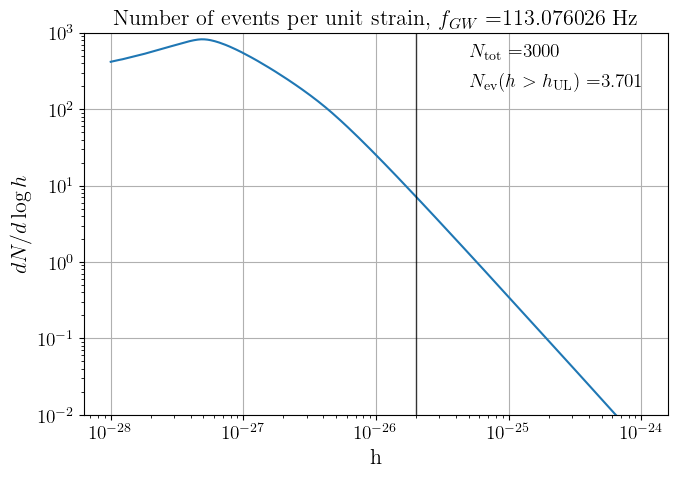

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16
hUL = 2E-26

Ntot = 3000

selh = (hList > hUL)
Nev = Ntot*np.trapz(dfdlogh[selh]/hList[selh], x=hList[selh])

ax.plot(hList, Ntot*dfdlogh)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'h', fontsize=font_s); ax.set_ylabel(r'$dN/d\log h$', fontsize=font_s); 
ax.set_title('Number of events per unit strain, $f_{GW} = $'+str(df_pulsars['F_GW'].iloc[p_ind])+' Hz', fontsize=font_s);
ax.text(5E-26, 5E2, r'$N_{\mathrm{tot}} =$'+str(Ntot))
ax.text(5E-26, 2E2, r'$N_{\mathrm{ev}}(h > h_{\mathrm{UL}}) =$'+str(round(Nev, 3)))
ax.axvline(x=hUL, linewidth=1, c='k', alpha=0.8)
ax.set_ylim(0.01,1000)
ax.grid()

fig.tight_layout()
#fig.savefig('figs/dndlogh.pdf', bbox_inches="tight")

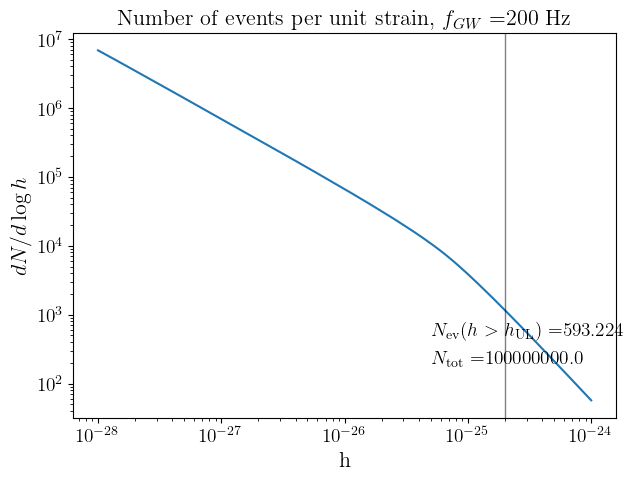

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16
hUL = 2E-25

Ntot = 1E8

selh = (hList > hUL)
Nev = Ntot*np.trapz(dfdlogh[selh]/hList[selh], x=hList[selh])

ax.plot(hList, Ntot*dfdlogh)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'h', fontsize=font_s); ax.set_ylabel(r'$dN/d\log h$', fontsize=font_s); 
ax.set_title('Number of events per unit strain, $f_{GW} = $'+str(freq_GW)+' Hz', fontsize=font_s);
ax.text(5E-26, 5E2, r'$N_{\mathrm{ev}}(h > h_{\mathrm{UL}}) =$'+str(round(Nev, 3)))
ax.text(5E-26, 2E2, r'$N_{\mathrm{tot}} =$'+str(Ntot))
ax.axvline(x=hUL, linewidth=1, c='k', alpha=0.5)

In [ ]:
hUL_list = np.geomspace(1E-27, 1E-24, 100)

Nev_List = np.zeros(len(hUL_list))
Ntot = 3000

for i, hUL in enumerate(hUL_list):
    selh = (hList > hUL)
    Nev_List[i] = Ntot*np.trapz(dfdlogh[selh]/hList[selh], x=hList[selh])

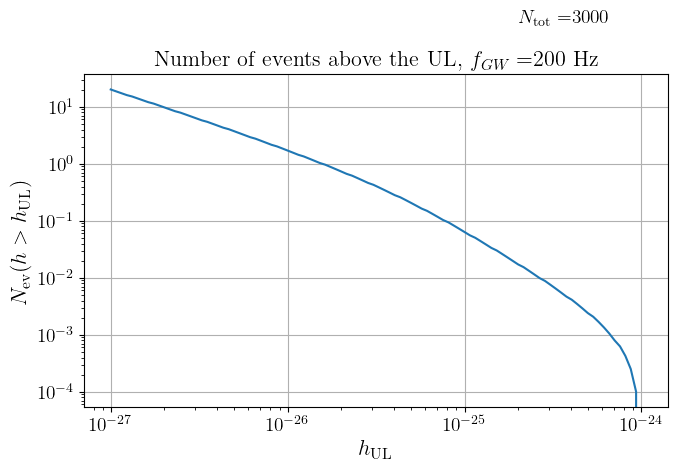

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16

#ax.plot(hUL_list, Nev_List, marker='.')
ax.plot(hUL_list, Nev_List)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'$h_{\mathrm{UL}}$', fontsize=font_s); ax.set_ylabel(r'$N_{\mathrm{ev}}(h>h_{\mathrm{UL}})$', fontsize=font_s); 
ax.set_title('Number of events above the UL, $f_{GW} = $'+str(freq_GW)+' Hz', fontsize=font_s);
ax.text(2E-25, 3E2, r'$N_{\mathrm{tot}} =$'+str(Ntot))
#ax.text(5E-26, 2E2, r'$N_{\mathrm{ev}}(h > h_{\mathrm{UL}}) =$'+str(round(Nev, 3)))
#ax.axvline(x=hUL, linewidth=1, c='k', alpha=0.5)
#ax.set_ylim(0.1,2000)
ax.grid()

fig.tight_layout()
fig.savefig('figs/NaboveUL.pdf', bbox_inches="tight")

### Result for multiple pulsars

In [ ]:
ipList = np.arange(5)
hList = np.geomspace(1E-27, 1E-24, 300)
dfdlogh_ip = np.zeros((len(ipList), len(hList)))

for ip in ipList:
    dfdlogh_ip[ip] = get_dfdlogh_ip(hList, p_ind=ip)

100%|██████████| 300/300 [00:32<00:00,  9.10it/s]


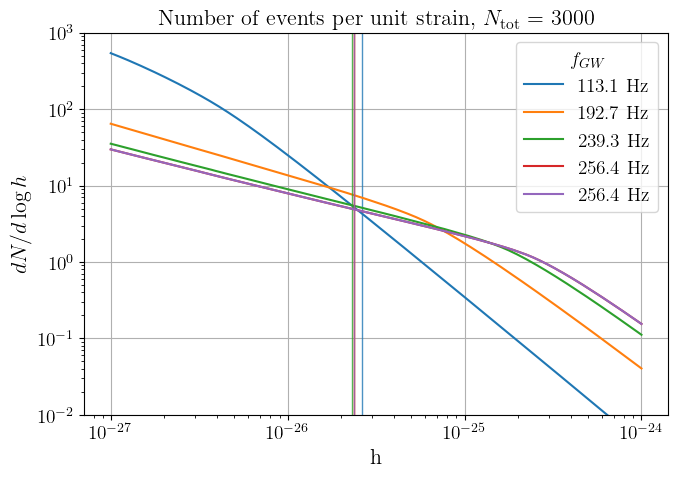

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green', 'teal'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16

Ntot = 3000

#selh = (hList > hUL)
#Nev = Ntot*np.trapz(dfdlogh[selh]/hList[selh], x=hList[selh])

for ip in ipList:
    line,=ax.plot(hList, Ntot*dfdlogh_ip[ip], label=str(round(df_pulsars['F_GW'].iloc[ip], 1))+' Hz')
    ax.axvline(x=df_pulsars['upper limits'].iloc[ip], linewidth=1, alpha=0.8, c=line.get_color())

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'h', fontsize=font_s); ax.set_ylabel(r'$dN/d\log h$', fontsize=font_s); 
ax.set_title('Number of events per unit strain, $N_{\mathrm{tot}} =$ '+str(Ntot), fontsize=font_s);
ax.legend(title='$f_{GW}$')
ax.set_ylim(0.01,1000)
ax.grid()

fig.tight_layout()
fig.savefig('figs/dndlogh_pulsars.pdf', bbox_inches="tight")

In [ ]:
Nev_above_th = np.zeros((len(ipList), 2))
Ntot = 3000

for ip in ipList:
    hUL = df_pulsars['upper limits'].iloc[ip]
    Nev_above_th[ip, 0] = df_pulsars['F_GW'].iloc[ip]
    
    selh = (hList > hUL)
    Nev_above_th[ip, 1] = Ntot*np.trapz(dfdlogh_ip[ip][selh]/hList[selh], x=hList[selh])

In [ ]:
Nev_above_th

array([[113.076026  ,   2.24134932],
       [192.72447   ,   7.15909379],
       [239.297466  ,   7.29607017],
       [256.410256  ,   6.95778353],
       [256.410256  ,   7.07009928]])

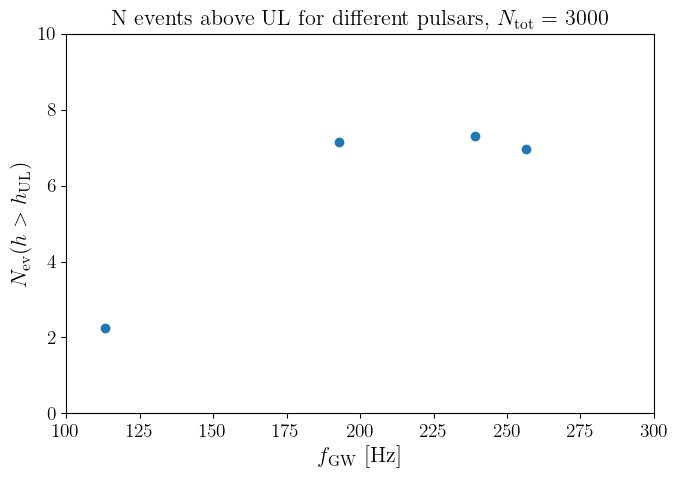

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16

ax.plot(Nev_above_th[:4, 0], Nev_above_th[:4, 1], 's', marker='o')

ax.set_title('N events above UL for different pulsars, $N_{\mathrm{tot}} =$ '+str(Ntot),fontsize=font_s);
ax.set_xlabel(r'$f_{\mathrm{GW}}$ [Hz]', fontsize=font_s); ax.set_ylabel(r'$N_{\mathrm{ev}}(h>h_{\mathrm{UL}})$', fontsize=font_s); 
#ax.grid()
ax.set_xlim(100,300); ax.set_ylim(0,10)

fig.tight_layout()
fig.savefig('figs/Nexpected.pdf', bbox_inches="tight")

### Events as a function of BH mass

In [ ]:
hList = np.geomspace(1E-27, 1E-24, 300)
dNevdlogM = np.zeros((len(ipList), len(MList)))

for ip in ipList:
    dNevdlogM[ip] = get_dNevdlogM_ip(Ntot=3000, p_ind=ip)

In [ ]:
ipList = np.arange(10)
Ntot = 3000

dfdlogh_ip = []
hList_ip = []
dNevdlogM = np.zeros((len(ipList), len(MList)))

for ip in ipList:
    dfdlogh_temp, hList_temp, dNevdlogM[ip] = get_Nev_distributions(Ntot=Ntot, p_ind=ip)
    
    dfdlogh_ip.append(dfdlogh_temp)
    hList_ip.append(hList_temp)

  0%|          | 1/300 [00:00<00:56,  5.27it/s]

4.5087199592263634e-33 1.2912119850325449e-20


  0%|          | 1/300 [00:00<00:57,  5.19it/s]

2.0289143569175353e-34 1.3662664328447774e-19


  0%|          | 1/300 [00:00<00:51,  5.84it/s]

5.846413378507335e-35 3.4175317521773275e-19


  0%|          | 1/300 [00:00<00:57,  5.17it/s]

3.949681946869707e-35 4.553443894931331e-19


  0%|          | 1/300 [00:00<00:50,  5.87it/s]

2.275387869391153e-35 6.757779052467087e-19


  0%|          | 0/300 [00:00<?, ?it/s]

1.0989751269329669e-35 1.138226866634089e-18


  0%|          | 1/300 [00:00<00:55,  5.36it/s]

7.028963803719848e-36 1.5554735587471555e-18


  0%|          | 1/300 [00:00<00:56,  5.33it/s]

5.0009901509276084e-36 1.9723951714700856e-18


  0%|          | 0/300 [00:00<?, ?it/s]

4.8365027409218574e-36 2.024137689526088e-18


  0%|          | 0/300 [00:00<?, ?it/s]

4.6894029781270726e-36 2.0640302401131903e-18


100%|██████████| 300/300 [1:56:30<00:00, 23.30s/it]    


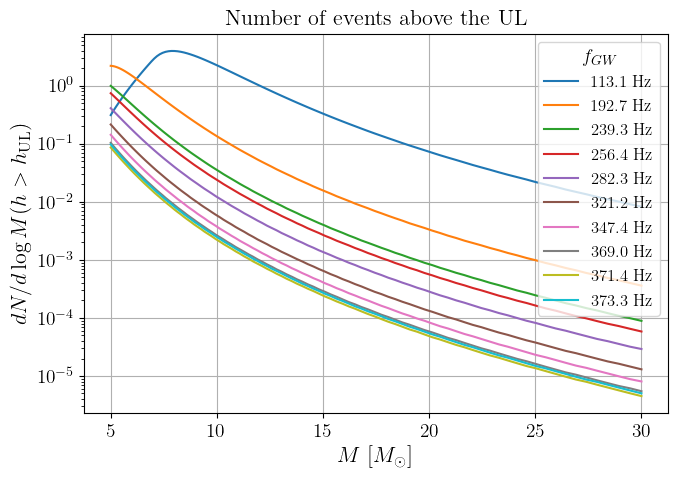

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16

for ip in ipList:
    line,=ax.plot(MList, dNevdlogM[ip], label=str(round(df_pulsars['F_GW'].iloc[ip], 1))+' Hz')

ax.set_yscale('log')
ax.set_xlabel(r'$M\ [M_{\odot}]$', fontsize=font_s); ax.set_ylabel(r'$dN/d\log M (h>h_{\mathrm{UL}})$', fontsize=font_s); 
ax.set_title('Number of events above the UL', fontsize=font_s);
ax.legend(title='$f_{GW}$', fontsize=12)
#ax.set_ylim(0.01,1000)
ax.grid()

fig.tight_layout()
#fig.savefig('figs/dndlogM_pulsars.pdf', bbox_inches="tight")

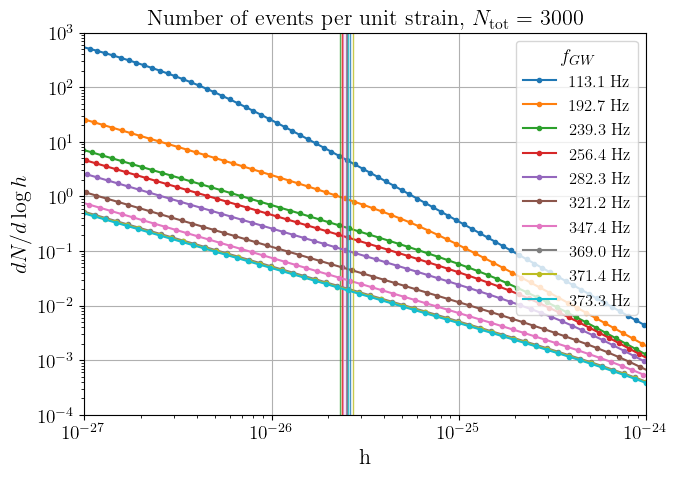

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green', 'teal'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16

Ntot = 3000

#selh = (hList > hUL)
#Nev = Ntot*np.trapz(dfdlogh[selh]/hList[selh], x=hList[selh])

for ip in ipList:
    line,=ax.plot(hList_ip[ip], Ntot*dfdlogh_ip[ip], label=str(round(df_pulsars['F_GW'].iloc[ip], 1))+' Hz', marker='.')
    ax.axvline(x=df_pulsars['upper limits'].iloc[ip], linewidth=1, alpha=0.8, c=line.get_color())

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'h', fontsize=font_s); ax.set_ylabel(r'$dN/d\log h$', fontsize=font_s); 
ax.set_title('Number of events per unit strain, $N_{\mathrm{tot}} =$ '+str(Ntot), fontsize=font_s);
ax.legend(title='$f_{GW}$', fontsize=12)
ax.set_xlim(1E-27,1E-24); ax.set_ylim(1E-4,1E3)
ax.grid()

fig.tight_layout()
#fig.savefig('figs/dndlogh_pulsars.pdf', bbox_inches="tight")

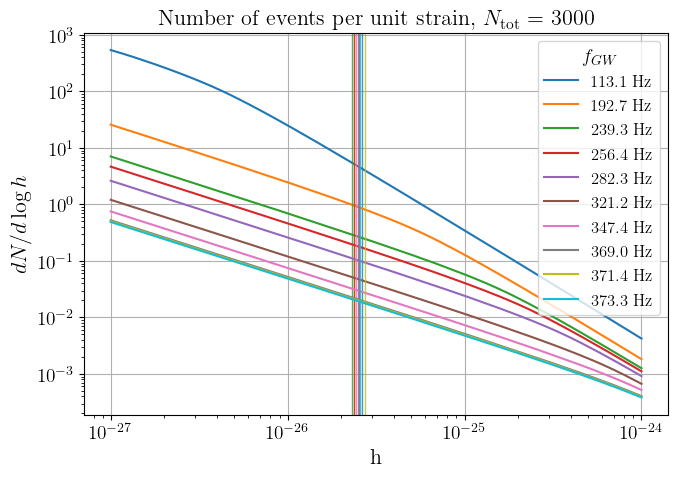

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green', 'teal'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16

Ntot = 3000

#selh = (hList > hUL)
#Nev = Ntot*np.trapz(dfdlogh[selh]/hList[selh], x=hList[selh])

for ip in ipList:
    line,=ax.plot(hList, Ntot*dfdlogh_ip[ip], label=str(round(df_pulsars['F_GW'].iloc[ip], 1))+' Hz')
    ax.axvline(x=df_pulsars['upper limits'].iloc[ip], linewidth=1, alpha=0.8, c=line.get_color())

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'h', fontsize=font_s); ax.set_ylabel(r'$dN/d\log h$', fontsize=font_s); 
ax.set_title('Number of events per unit strain, $N_{\mathrm{tot}} =$ '+str(Ntot), fontsize=font_s);
ax.legend(title='$f_{GW}$', fontsize=12)
#ax.set_ylim(0.01,1000)
ax.grid()

fig.tight_layout()
fig.savefig('figs/dndlogh_pulsars.pdf', bbox_inches="tight")

In [ ]:
Nev_above_th = np.zeros((len(ipList), 2))
Ntot = 3000

for ip in ipList:
    hUL = df_pulsars['upper limits'].iloc[ip]
    Nev_above_th[ip, 0] = df_pulsars['F_GW'].iloc[ip]
    
    selh = (hList > hUL)
    Nev_above_th[ip, 1] = Ntot*np.trapz(dfdlogh_ip[ip][selh]/hList[selh], x=hList[selh])

In [ ]:
Nev_above_th

array([[1.13076026e+02, 2.24134932e+00],
       [1.92724470e+02, 6.87761794e-01],
       [2.39297466e+02, 2.48294371e-01],
       [2.56410256e+02, 1.66902924e-01],
       [2.82290106e+02, 9.30834868e-02],
       [3.21185420e+02, 4.44811274e-02],
       [3.47416438e+02, 2.95183970e-02],
       [3.69003690e+02, 1.97115548e-02],
       [3.71448554e+02, 1.72114428e-02],
       [3.73303340e+02, 1.79668894e-02]])

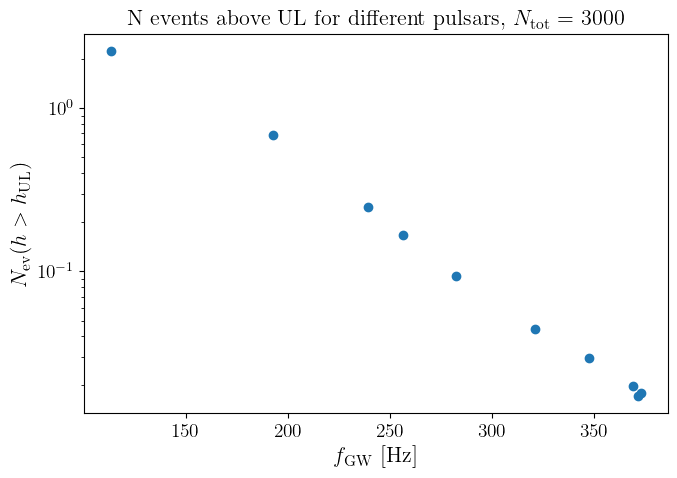

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16

ax.plot(Nev_above_th[:, 0], Nev_above_th[:, 1], 's', marker='o')

ax.set_title('N events above UL for different pulsars, $N_{\mathrm{tot}} =$ '+str(Ntot),fontsize=font_s);
ax.set_xlabel(r'$f_{\mathrm{GW}}$ [Hz]', fontsize=font_s); ax.set_ylabel(r'$N_{\mathrm{ev}}(h>h_{\mathrm{UL}})$', fontsize=font_s); 
ax.set_yscale('log')
#ax.grid()
#ax.set_xlim(100,300); #ax.set_ylim(0,10)

fig.tight_layout()
fig.savefig('figs/Nexpected.pdf', bbox_inches="tight")

## Number of events as a function of luminosity

In [ ]:
### One frequency 

SList = np.geomspace(1E-2, 1E5, 300)*STh
dfdlogS = np.zeros(SList.shape)
fepsSq = 1E-6*(1E-9)**2

fMList = dndM(MList)

for i_S, SVal in enumerate(tqdm(SList)):    

    dfdlogS[i_S] = get_dfdlogS(SVal, STilde, tGrid, fMList, fepsSq)

100%|██████████| 300/300 [00:37<00:00,  7.98it/s]


In [ ]:
### Multiple frequencies

ipList = np.arange(10)

BW = 2*GHz
STh = 70*(1E-6)*Jy*BW/(erg/Second/CentiMeter**2)
SList = np.geomspace(1E-2, 1E5, 300)*STh

fepsSq = 1E-6*(1E-9)**2

dfdlogS_ip = np.zeros((len(ipList), len(SList)))

for ip in ipList:
    dfdlogS_ip[ip] = get_dfdlogS_ip(SList, fepsSq, p_ind=ip)

100%|██████████| 300/300 [00:33<00:00,  8.94it/s]


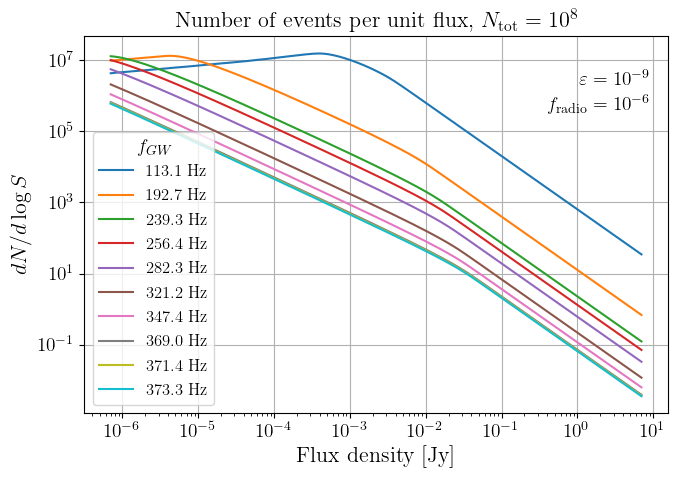

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green', 'teal'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16

Ntot = 1E8

for ip in ipList:
    line,= ax.plot(SList*(erg/Second/CentiMeter**2)/BW/Jy, Ntot*dfdlogS_ip[ip], label=str(round(df_pulsars['F_GW'].iloc[ip], 1))+' Hz')
    
#ax.axvline(x=STh*(erg/Second/CentiMeter**2)/BW/Jy, linewidth=1, alpha=0.8, c='k')

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'Flux density [Jy]', fontsize=font_s); ax.set_ylabel(r'$dN/d\log S$', fontsize=font_s); 
ax.set_title('Number of events per unit flux, $N_{\mathrm{tot}} = 10^8$', fontsize=font_s);
ax.text(1.05, 2E6, r'$\varepsilon = 10^{-9}$')
ax.text(0.4, 4E5, r'$f_{\mathrm{radio}} = 10^{-6}$')
ax.legend(title='$f_{GW}$', fontsize=12)
#ax.set_ylim(0.01,1000)
ax.grid()

fig.tight_layout()
fig.savefig('figs/dndlogS_pulsars.pdf', bbox_inches="tight")

In [ ]:
Nev_above_th = np.zeros((len(ipList), 2))
Ntot = 1E8

BW = 2*GHz
STh = 0.1*(1E-3)*Jy*BW/(erg/Second/CentiMeter**2)

for ip in ipList:
    Nev_above_th[ip, 0] = df_pulsars['F_GW'].iloc[ip]
    
    selS = (SList > STh)
    Nev_above_th[ip, 1] = Ntot*np.trapz(dfdlogS_ip[ip][selS]/SList[selS], x=SList[selS])

In [ ]:
Nev_above_th

array([[1.13076026e+02, 4.06459499e+07],
       [1.92724470e+02, 1.45172516e+06],
       [2.39297466e+02, 2.23388866e+05],
       [2.56410256e+02, 1.21692452e+05],
       [2.82290106e+02, 5.20611873e+04],
       [3.21185420e+02, 1.65675426e+04],
       [3.47416438e+02, 8.24638382e+03],
       [3.69003690e+02, 4.82242729e+03],
       [3.71448554e+02, 4.54715608e+03],
       [3.73303340e+02, 4.35032257e+03]])

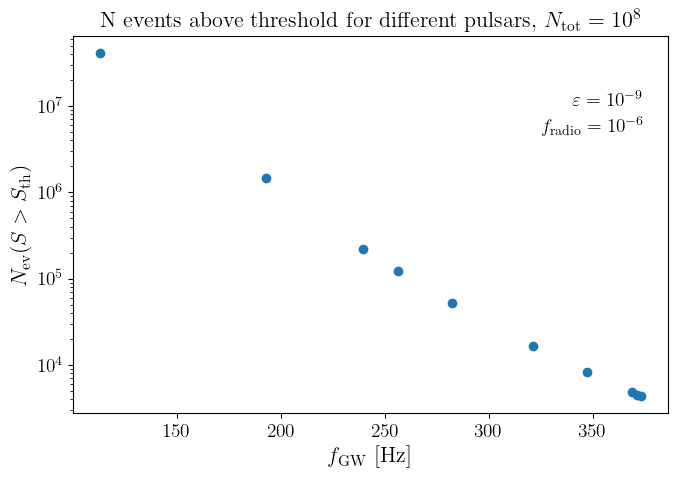

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16

ax.plot(Nev_above_th[:, 0], Nev_above_th[:, 1], 's', marker='o')

ax.set_title('N events above threshold for different pulsars, $N_{\mathrm{tot}} = 10^8$',fontsize=font_s);
ax.set_xlabel(r'$f_{\mathrm{GW}}$ [Hz]', fontsize=font_s); ax.set_ylabel(r'$N_{\mathrm{ev}}(S>S_{\mathrm{th}})$', fontsize=font_s); 
ax.set_yscale('log')
ax.text(340, 1E7, r'$\varepsilon = 10^{-9}$')
ax.text(325, 5E6, r'$f_{\mathrm{radio}} = 10^{-6}$')
#ax.set_xlim(100,300); ax.set_ylim(0,10)

fig.tight_layout()
fig.savefig('figs/Nexpected_S.pdf', bbox_inches="tight")

## Plots

Normalization =  1.0002145481580622


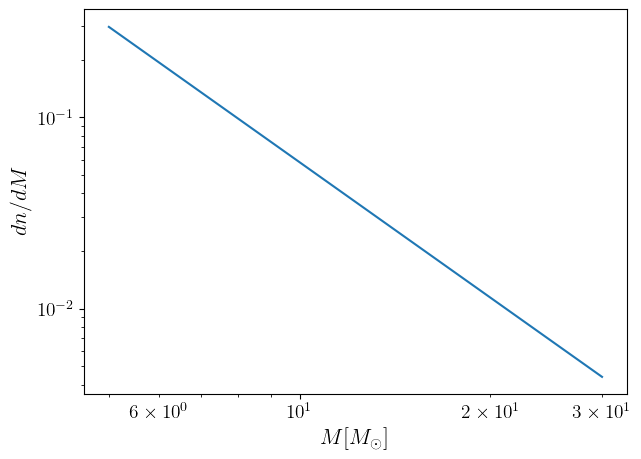

In [ ]:
### BH mass distributon

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
font_s=16

MList = np.geomspace(Mmin, Mmax, 100) #np.arange(Mmin, Mmax, 0.2)
print('Normalization = ', str(np.trapz(dndM(MList), x=MList)))

ax.plot(MList, dndM(MList))
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'$M [M_{\odot}]$', fontsize=font_s)
ax.set_ylabel(r'$dn/dM$', fontsize=font_s);

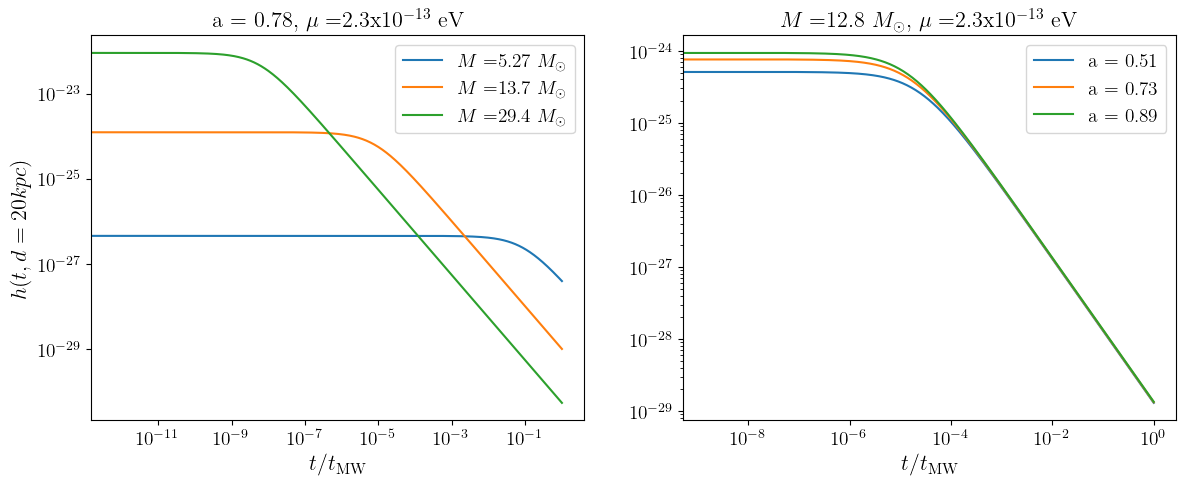

In [ ]:
### Check the computed strains hTilde for a few valaues of M and a

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16
sub_im = np.array([3, 56, 98])
i_a = 78

mu = np.pi*df_pulsars['F_GW'].iloc[p_ind]*Hz

for i in sub_im:
    ax[0].plot(tGrid[i, i_a, :], hTilde[i, i_a, :], label=r'$M = $'+str(MList[i])[:4]+'$\ M_{\odot}$')
    
i_m = 52
sub_ia = np.array([51, 73, 89])

for i in sub_ia:
    ax[1].plot(tGrid[i_m, i, :], hTilde[i_m, i, :], label=r'a = '+str(aList[i])[:4])

ax[0].set_title(r'a = '+str(aList[i_a])[:4]+', $\mu = $'+str(mu/eV/1e-13)[:3]+'x$10^{-13}$ eV', fontsize=font_s);
ax[1].set_title(r'$M = $'+str(MList[i_m])[:4]+'$\ M_{\odot}$, $\mu = $'+str(mu/eV/1e-13)[:3]+'x$10^{-13}$ eV', fontsize=font_s);

for i in range(2):
    ax[i].set_xscale('log'); ax[i].set_yscale('log')
    ax[i].set_xlabel(r'$t/t_{\mathrm{MW}}$', fontsize=font_s)
    ax[0].set_ylabel(r'$h(t, d=20 kpc)$', fontsize=font_s);
    ax[i].legend()

# Tests

In [ ]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

In [ ]:
mbh = 10
abh0 = 0.5
alpha = 0.02

wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")

if wf.azimuthal_num()==1:
    tauGW = wf.gw_time()*Second

In [ ]:
tauSR = wf.cloud_growth_time()
tauGW = wf.gw_time()
tauSR/1E9, tauGW/1e13

(4.345572030927802, 2.84590924589311)

In [ ]:
wf.strain_char(-10, dObs=0.001) # distance in Mpc

4.5728003476743694e-24

In [ ]:
wf.strain_char(-1E9, dObs=0.001)

6.532471187190322e-42

In [ ]:
tList = np.geomspace(1E-5,1E7,100)*tauGW #np.concatenate([ np.sort(np.logspace(-9,0,50)*(-tauSR)), np.logspace(-13, 2, 200)*tauGW ] )  
hList = wf.strain_char(tList, dObs=0.001)

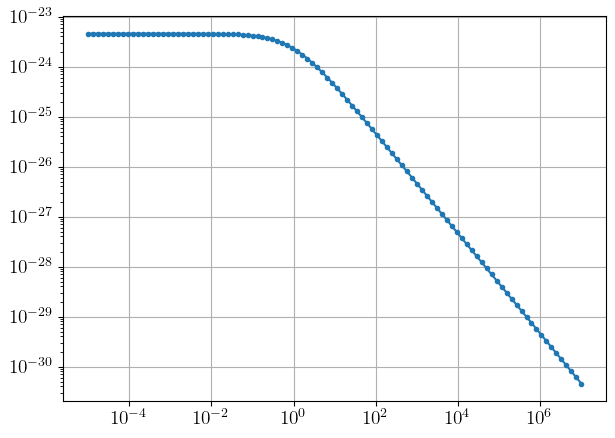

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']

#ax.plot((tList+tauSR)[1:], hList[1:])
ax.plot(tList/tauGW, hList, marker='.')
ax.set_xscale('log'); ax.set_yscale('log')
ax.grid()

In [ ]:
def get_dfdlogh_diff(hVal, hTilde, fMList):
    
    thFnc = np.heaviside((hVal/hTilde-1), np.zeros(hTilde.shape))
    integrand = 3*( (hTilde/hVal) )**3*thFnc*fMList[:,None,None]
    
    return integrand

In [ ]:
hList = np.geomspace(1E-28, 1E-24, 100)

hList_Grid = np.full((len(hList),len(MList), len(aList), tSteps), hList[:, np.newaxis, np.newaxis, np.newaxis])

hTilde_Gridh = np.full((len(hList),len(MList), len(aList), tSteps), hTilde[np.newaxis, :, :, :])
print(hList_Grid.shape, hTilde_Gridh.shape)

(100, 100, 100, 500) (100, 100, 100, 500)


In [ ]:
fMList = dndM(MList)
fMList.shape

(100,)

In [ ]:
thFnc = np.heaviside((1-hTilde_Gridh/hList_Grid), np.zeros(hTilde_Gridh.shape))

In [ ]:
thFnc.shape